<a href="https://colab.research.google.com/github/bikash119/bikash119/blob/main/learn_pytorch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification NN

## Prepare Data

In [1]:
from sklearn.datasets import make_circles

#make 1000 samples
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.05,
                   random_state=42) 

In [2]:
print(f'First 5 entries of feature X \n {X[:5]} \n')
print(f'First 5 entires of label y \n {y[:5]}')

First 5 entries of feature X 
 [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]] 

First 5 entires of label y 
 [1 1 1 1 0]


In [3]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],"X2": X[:,1],"label" :y})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

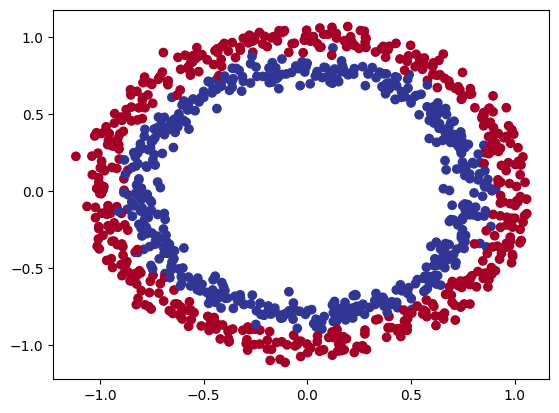

In [5]:
## visualize the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu); 

In [6]:
print(f'Shape of X is {X[0].shape} and y is{y[0].shape}')

Shape of X is (2,) and y is()


In [7]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## Check cuda availability to write device agnostic code

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

## Build the model
### iter 1

In [10]:
from torch import nn
class ColorClassifierV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
  
  def forward(self,x):
    return self.layer_2(self.layer_1(x))


model_v0 = ColorClassifierV1().to(device)
model_v0


ColorClassifierV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

## Above model can be implemented with less code using nn.sequential

In [11]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
X_test.shape

torch.Size([200, 2])

In [13]:
untrained_preds= model_0(X_test.to(device))
print(f' Length of untrained_preds : {len(untrained_preds)}, shape : {untrained_preds.shape}')
print(f' Lenght of test label : {len(y_test)}, shape: {y_test.shape}')
print(f' First 10 untrained predictions : {untrained_preds[:10]}')
print(f' First 10 test labels : {y_test[:10]}')

 Length of untrained_preds : 200, shape : torch.Size([200, 1])
 Lenght of test label : 200, shape: torch.Size([200])
 First 10 untrained predictions : tensor([[0.2138],
        [0.1201],
        [0.4149],
        [0.1495],
        [0.3679],
        [0.3076],
        [0.0882],
        [0.1291],
        [0.4279],
        [0.1175]], device='cuda:0', grad_fn=<SliceBackward0>)
 First 10 test labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Decide & Define the evaluation metric

In [14]:
def accuracy_fn(y_pred,y_true):
  correct = torch.eq(y_pred,y_true).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

#### The output of forward pass is called logits. Since the logits are not directly comparable to the true values, we need to use sigmoid function to transform the logits in order to make them comparable to true values. 

In [15]:
y_logits = model_0(X_train[:5].to(device))
y_logits

tensor([[0.2758],
        [0.3324],
        [0.4223],
        [0.4350],
        [0.1673]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5685],
        [0.5824],
        [0.6040],
        [0.6071],
        [0.5417]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [17]:
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

## Create the loss function and optimizer

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

## Train the model ( iter 1)


> Using loss function as BCEWithLogitsLoss()





In [19]:
random_state= 42
epochs = 100
X_train, y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  ## train the model
  model_0.train()

  ## peform forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  ## calculate loss 
    ### we are passing the raw logits here 
    ### because the loss function can take 
    ### raw logits and calculate loss

  loss = loss_fn(y_logits,y_train) 

  ## Train accuracy
  train_acc = accuracy_fn(y_preds,y_train)

  ## zero_grad
  optimizer.zero_grad()

  ## backprop
  loss.backward()

  ## update parameters
  optimizer.step()

  ## Evaluate model
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(test_preds,y_test)

  if epoch % 10 == 0:
    print(f' Epoch : {epoch} Train Loss : {loss:.5f}, Train acc: {train_acc:.2f}, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}')

 Epoch : 0 Train Loss : 0.70654, Train acc: 50.00, Test loss: 0.69909, Test acc: 50.00
 Epoch : 10 Train Loss : 0.70011, Train acc: 50.00, Test loss: 0.69457, Test acc: 50.00
 Epoch : 20 Train Loss : 0.69695, Train acc: 57.12, Test loss: 0.69276, Test acc: 58.50
 Epoch : 30 Train Loss : 0.69534, Train acc: 55.62, Test loss: 0.69216, Test acc: 53.50
 Epoch : 40 Train Loss : 0.69447, Train acc: 54.25, Test loss: 0.69209, Test acc: 52.00
 Epoch : 50 Train Loss : 0.69397, Train acc: 52.88, Test loss: 0.69224, Test acc: 51.00
 Epoch : 60 Train Loss : 0.69366, Train acc: 52.25, Test loss: 0.69248, Test acc: 50.50
 Epoch : 70 Train Loss : 0.69346, Train acc: 51.50, Test loss: 0.69274, Test acc: 51.00
 Epoch : 80 Train Loss : 0.69333, Train acc: 50.38, Test loss: 0.69299, Test acc: 56.00
 Epoch : 90 Train Loss : 0.69324, Train acc: 50.12, Test loss: 0.69323, Test acc: 54.00


### Plot decision boundary for Train and test prediction


---
Should learn how to create decision boundary charts


In [20]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

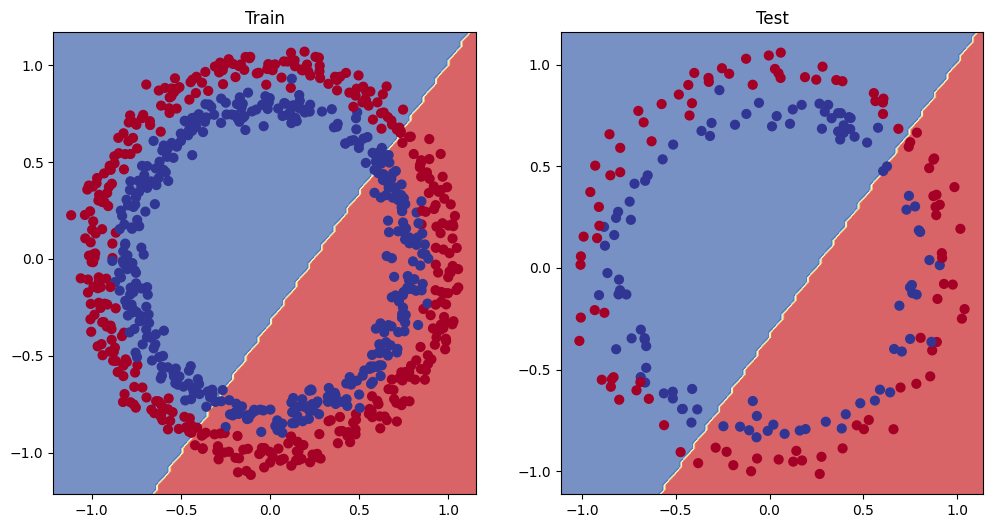

In [21]:


# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



# Improve the model
## Approach 1


1.   Increase the number of Layers
2.   Increase the number of hidden units from 5 to 10
3. Increase the number of epochs to 300



In [22]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2,out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [23]:
loss_fn

BCEWithLogitsLoss()

In [24]:
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Training loop 2

In [25]:
random_state=42
epochs = 1000

for epoch in range(epochs):
  ## Train the model
  model_1.train()

  ## forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  ## Loss
  loss = loss_fn(y_logits,y_train)
  train_acc = accuracy_fn(y_preds,y_train)

  ## zero grad
  optimizer.zero_grad()

  ## backprop
  loss.backward()

  ## update parameters
  optimizer.step()

  ## Evaluate model
  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(test_preds,y_test)

  if epoch % 100 == 0:
    print(f'Epoch : {epoch} , Train loss: {loss:.4f}, Train accuracy: {train_acc:.2f}, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}')

Epoch : 0 , Train loss: 0.7117, Train accuracy: 50.00, Test loss: 0.7096, Test accuracy: 50.00
Epoch : 100 , Train loss: 0.6931, Train accuracy: 48.75, Test loss: 0.6934, Test accuracy: 51.00
Epoch : 200 , Train loss: 0.6930, Train accuracy: 50.88, Test loss: 0.6940, Test accuracy: 46.50
Epoch : 300 , Train loss: 0.6930, Train accuracy: 51.38, Test loss: 0.6944, Test accuracy: 46.50
Epoch : 400 , Train loss: 0.6930, Train accuracy: 51.25, Test loss: 0.6945, Test accuracy: 46.00
Epoch : 500 , Train loss: 0.6930, Train accuracy: 51.12, Test loss: 0.6946, Test accuracy: 46.00
Epoch : 600 , Train loss: 0.6930, Train accuracy: 51.00, Test loss: 0.6946, Test accuracy: 46.00
Epoch : 700 , Train loss: 0.6930, Train accuracy: 51.38, Test loss: 0.6947, Test accuracy: 45.50
Epoch : 800 , Train loss: 0.6930, Train accuracy: 51.50, Test loss: 0.6947, Test accuracy: 45.50
Epoch : 900 , Train loss: 0.6930, Train accuracy: 51.50, Test loss: 0.6947, Test accuracy: 45.50


## Lets plot the decision boundary again

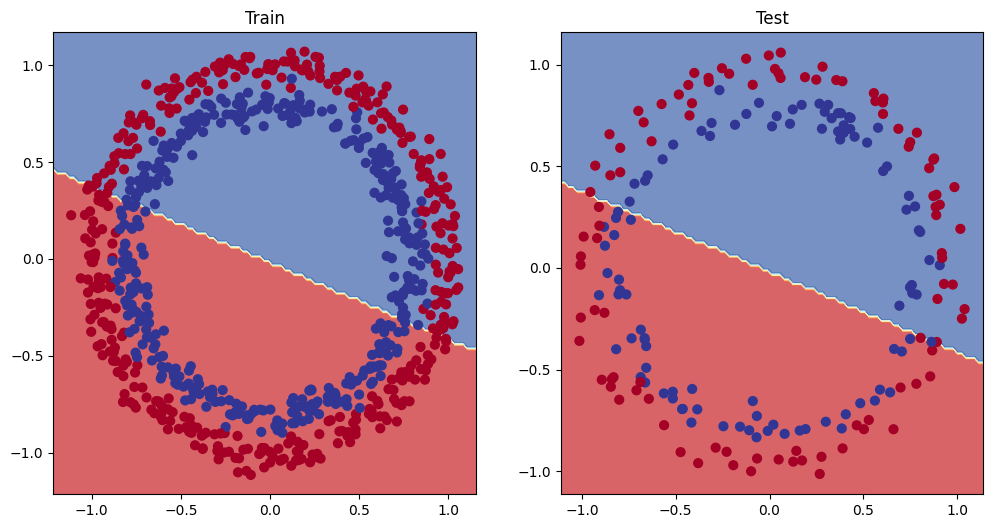

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The model is still drawing a straight line. Can it predict on linear data. Let's try to check if the model can learn from linear data?


### Prepare Linear Data

In [27]:
weight = 0.7
bias = 0.3
start =0
end = 1
step = 0.01
X_regression=torch.arange(start,end,step).unsqueeze(dim=1)
y_regression=weight * X_regression + bias
print(len(X_regression))
X_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [28]:
### train / test split

X_train_regression , X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression,y_regression,test_size=0.2)

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

In [29]:
train_split = int(0.8 * len(X_regression))
X_train_regression1 , X_test_regression1 = X_regression[:train_split], X_regression[train_split:]
y_train_regression1, y_test_regression1 = y_regression[:train_split] , y_regression[train_split:]

len(X_train_regression1), len(X_test_regression1), len(y_train_regression1), len(y_test_regression1)

(80, 20, 80, 20)

In [30]:
def plot_prediction(train_data= X_train_regression, train_label=y_train_regression,
                    test_data=X_test_regression,test_label=y_test_regression,prediction=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_label, c='r', s=14, label="Train")
  plt.scatter(test_data,test_label, c='b', s=14, label="Test")
  if prediction is not None:
    plt.scatter(test_data,prediction,c='g', s=14, label="prediction")
  plt.legend(prop={"size" :14})

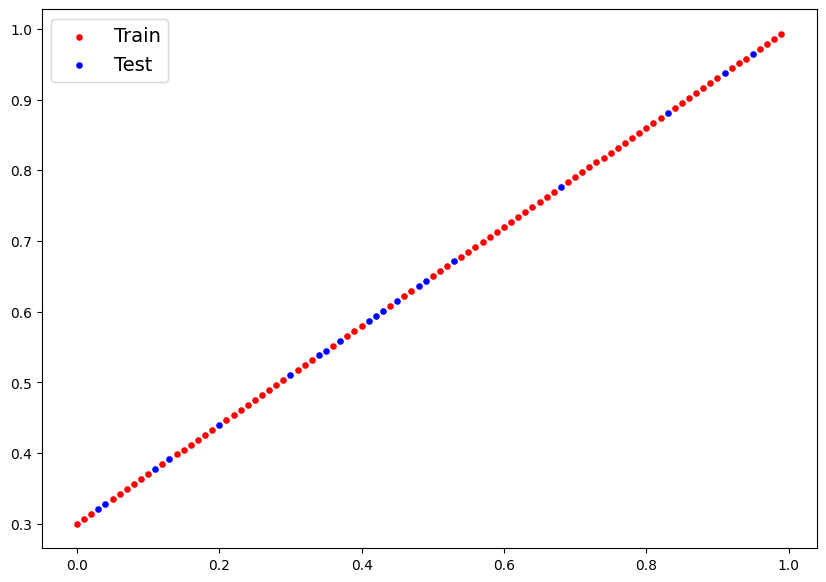

In [31]:
plot_prediction()

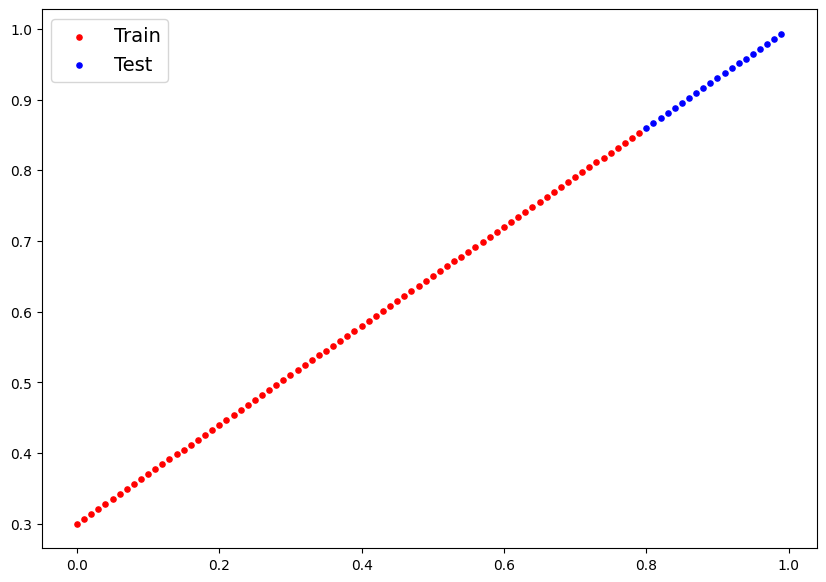

In [32]:
plot_prediction(train_data=X_train_regression1,train_label=y_train_regression1,
                test_data=X_test_regression1,test_label=y_test_regression1)

## Define the model, loss function and optimizer

In [33]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)
regression_loss_fn = nn.L1Loss()
reg_optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)
model_2, regression_loss_fn, reg_optimizer

(Sequential(
   (0): Linear(in_features=1, out_features=10, bias=True)
   (1): Linear(in_features=10, out_features=10, bias=True)
   (2): Linear(in_features=10, out_features=1, bias=True)
 ),
 L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## Perform the training loop

In [34]:
random_state = 42
epochs = 1000
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

  ##Train the model
  model_2.train()

  ## Forward pass
  y_preds = model_2(X_train_regression)

  ## loss
  loss = regression_loss_fn(y_preds,y_train_regression)


  ## Zero grad
  reg_optimizer.zero_grad()

  ## backprop
  loss.backward()

  ## update parameters
  reg_optimizer.step()

  ## Evaluate model
  model_2.eval()

  with torch.inference_mode():
    test_preds = model_2(X_test_regression)
    test_loss = regression_loss_fn(test_preds,y_test_regression)

  if epoch % 100 == 0:
    print(f'Epoch : {epoch}, Train loss: {loss:.4f}, Test loss: {test_loss:.4f}')


Epoch : 0, Train loss: 0.1217, Test loss: 0.3233
Epoch : 100, Train loss: 0.1225, Test loss: 0.0750
Epoch : 200, Train loss: 0.1023, Test loss: 0.0611
Epoch : 300, Train loss: 0.0651, Test loss: 0.0861
Epoch : 400, Train loss: 0.0527, Test loss: 0.0914
Epoch : 500, Train loss: 0.0704, Test loss: 0.0660
Epoch : 600, Train loss: 0.0680, Test loss: 0.0651
Epoch : 700, Train loss: 0.0750, Test loss: 0.0597
Epoch : 800, Train loss: 0.0559, Test loss: 0.0550
Epoch : 900, Train loss: 0.0746, Test loss: 0.0578


In [35]:
with torch.inference_mode():
  reg_predictions=model_2(y_test_regression)
reg_predictions

tensor([[0.6418],
        [0.6686],
        [0.5659],
        [0.6775],
        [0.8830],
        [0.4944],
        [0.5346],
        [0.7133],
        [0.8472],
        [0.5257],
        [0.6909],
        [0.4899],
        [0.9008],
        [0.6284],
        [0.6329],
        [0.6597],
        [0.6954],
        [0.6641],
        [0.7803],
        [0.6105]], device='cuda:0')

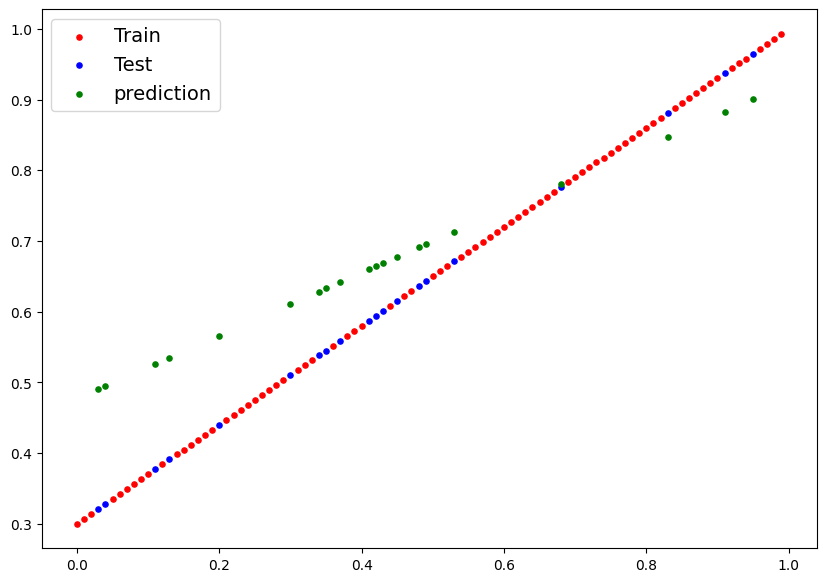

In [36]:
plot_prediction(train_data=X_train_regression.cpu(),
                train_label=y_train_regression.cpu(),
                test_data = X_test_regression.cpu(),
                test_label=y_test_regression.cpu(),
    prediction=reg_predictions.cpu())

#### Hence we can see the linear model is able to learn parameters from linear data. 
#### We will have to add some non-linearity to our model as the data from make_circles() is non-linear

In [42]:
model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    #nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
    #nn.ReLU()
).to(device)
model_3

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=1, bias=True)
)

### Define the loss function
### Define the optimizer

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.1)

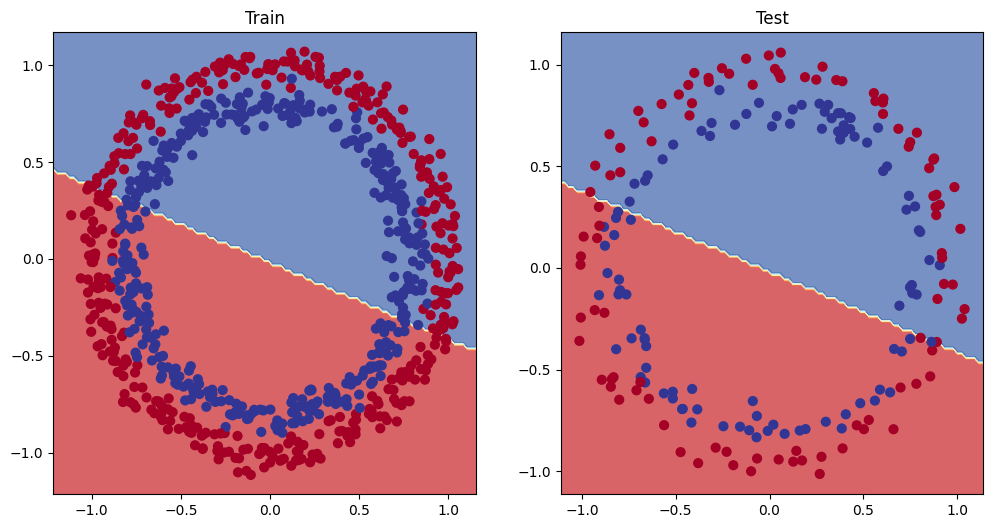

In [44]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [45]:
## Training loop
random_seed = 42
epochs = 1000
torch.manual_seed(random_seed)
X_train, X_test =X_train.to(device),X_test.to(device)
y_train, y_test =y_train.to(device),y_test.to(device)
for epoch in range(epochs):

  ## train the model
  model_3.train()

  ## forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  ## Calculate loss
  loss = loss_fn(y_logits,y_train)

  ## calculate Accuracy
  acc = accuracy_fn(y_preds,y_train)

  ## Zero grad
  optimizer.zero_grad()

  ## backprop
  loss.backward()

  ## update parameters
  optimizer.step()

  ## Evaluate model
  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(test_preds,y_test)

  if epoch % 100 == 0:
    print(f'epoch : {epoch}, Train loss: {loss:.4f}, Train acc : {acc: .2f}% , Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

epoch : 0, Train loss: 0.6983, Train acc :  50.00% , Test loss: 0.6984, Test acc: 49.50%
epoch : 100, Train loss: 0.6929, Train acc :  50.62% , Test loss: 0.6942, Test acc: 49.00%
epoch : 200, Train loss: 0.6902, Train acc :  53.75% , Test loss: 0.6916, Test acc: 50.00%
epoch : 300, Train loss: 0.6877, Train acc :  57.25% , Test loss: 0.6888, Test acc: 54.50%
epoch : 400, Train loss: 0.6847, Train acc :  59.50% , Test loss: 0.6853, Test acc: 61.00%
epoch : 500, Train loss: 0.6793, Train acc :  56.25% , Test loss: 0.6793, Test acc: 59.50%
epoch : 600, Train loss: 0.6725, Train acc :  56.88% , Test loss: 0.6732, Test acc: 60.50%
epoch : 700, Train loss: 0.6625, Train acc :  66.12% , Test loss: 0.6663, Test acc: 64.00%
epoch : 800, Train loss: 0.6462, Train acc :  76.50% , Test loss: 0.6554, Test acc: 70.00%
epoch : 900, Train loss: 0.6207, Train acc :  83.62% , Test loss: 0.6360, Test acc: 77.00%


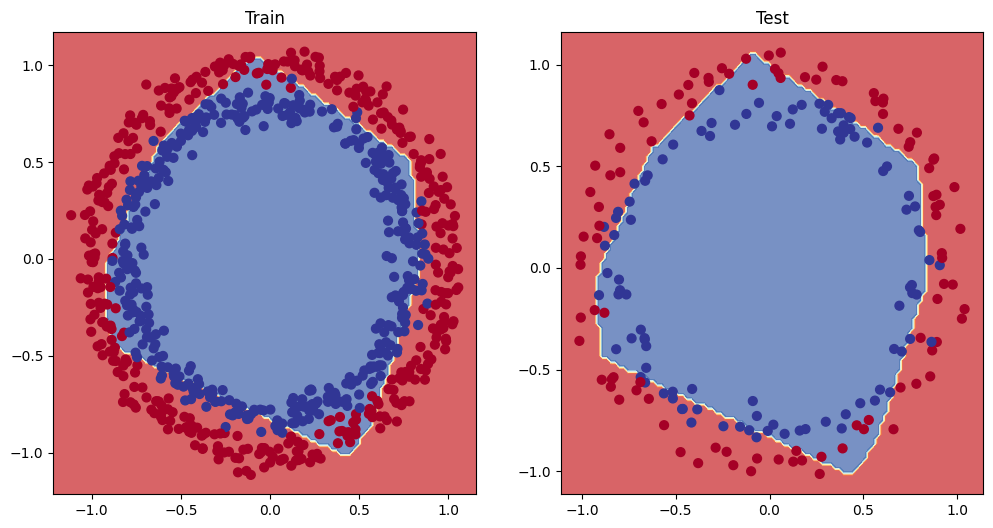

In [91]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X=X_test, y=y_test)

## Multi-class classification

### Prepare the data

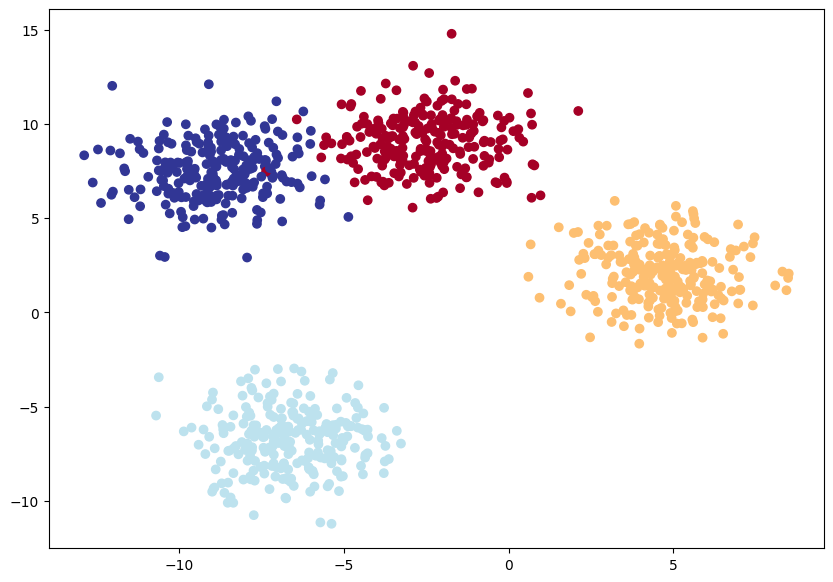

In [55]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hpyerparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

## Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train,X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
    )

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

### Create the model

In [93]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x)-> torch.Tensor:
      return self.linear_layer_stack(x)
  

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create the Loss function and Optimizer

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_4.parameters(),lr=0.1)
loss_fn,optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## To convert raw model outputs ( logits ) to prediction probabilities, we need to use 
`torch.softmax`

In [95]:
y_logits = model_4(X_blob_train.to(device))[:5]

In [96]:
y_logits[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [97]:
y_pred_probs = torch.softmax(y_logits,dim=1)

In [98]:
y_pred_probs[:5]

tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [99]:
torch.sum(y_pred_probs[:1])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

## training loop

In [102]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000
X_blob_train, X_blob_test = X_blob_train.to(device),X_blob_test.to(device)
y_blob_train,y_blob_test = y_blob_train.to(device),y_blob_test.to(device)

for epoch in range(epochs):

  ## train the model
  model_4.train()

  ## forward pass
  y_logits = model_4(X_blob_train).squeeze()
  y_preds = torch.softmax(y_logits,dim=1).argmax(dim=1)

  ## calculat loss 
  loss = loss_fn(y_logits,y_blob_train)

  ## calculate accuracy
  acc = accuracy_fn(y_preds,y_blob_train)

  ## zero grad
  optimizer.zero_grad()

  ## backprop
  loss.backward()

  ## update parameters
  optimizer.step()

  ## Evaluate model
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(test_preds,y_blob_test)

  if epoch % 100 == 0:
    print(f''' epoch : {epoch}, train loss: {loss:.4f}, train acc: {acc:.2f}%, 
                test loss: {test_loss:.4f}, test_acc: {test_acc:.2f}%''')

 epoch : 0, train loss: 0.0205, train acc: 99.50%, 
                test loss: 0.0092, test_acc: 99.50%
 epoch : 100, train loss: 0.0203, train acc: 99.50%, 
                test loss: 0.0091, test_acc: 99.50%
 epoch : 200, train loss: 0.0202, train acc: 99.50%, 
                test loss: 0.0089, test_acc: 99.50%
 epoch : 300, train loss: 0.0200, train acc: 99.50%, 
                test loss: 0.0088, test_acc: 99.50%
 epoch : 400, train loss: 0.0199, train acc: 99.50%, 
                test loss: 0.0087, test_acc: 99.50%
 epoch : 500, train loss: 0.0197, train acc: 99.50%, 
                test loss: 0.0085, test_acc: 99.50%
 epoch : 600, train loss: 0.0196, train acc: 99.50%, 
                test loss: 0.0084, test_acc: 99.50%
 epoch : 700, train loss: 0.0195, train acc: 99.50%, 
                test loss: 0.0083, test_acc: 99.50%
 epoch : 800, train loss: 0.0193, train acc: 99.50%, 
                test loss: 0.0081, test_acc: 99.50%
 epoch : 900, train loss: 0.0192, train acc: 99.

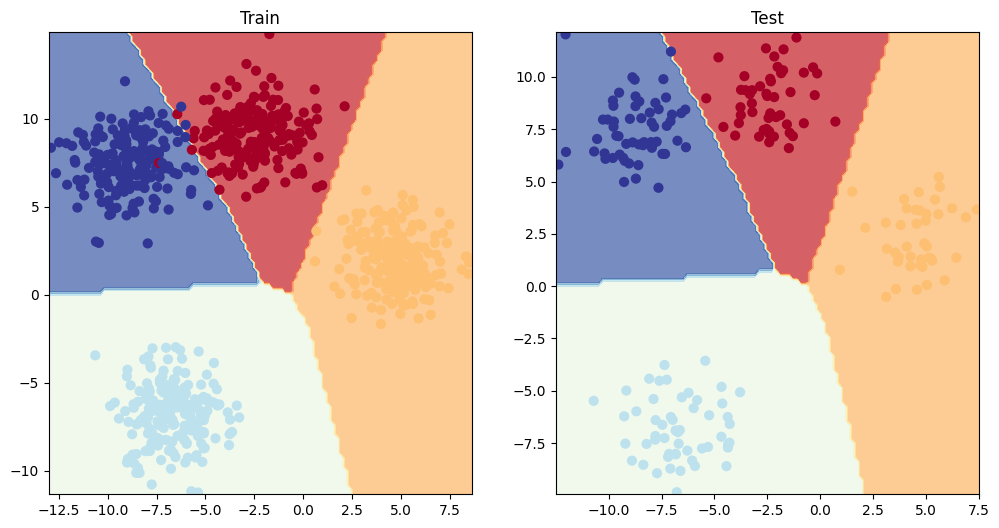

In [103]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X=X_blob_train, y=y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X=X_blob_test, y=y_blob_test)